In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import process # se usa para hacer match de strings

In [16]:
mle_2023_df = pd.read_csv("data/sample/MLE_2023_sample_limpio.csv", encoding='latin1')

## 3. ¿Qué tipos de prestación médica son más frecuentes en cada región?

**Aclaraciones**  

- Usaremos el archivo **Regional.shp** para graficar el mapa de Chile, con las regiones delimitadas.
  
- Utilizaremos la librería **fuzzywuzzy** (específicamente `from fuzzywuzzy import process`) para hacer coincidir los nombres de regiones en el DataFrame **mle_2023_df** con los nombres presentes en el shapefile **mapa**.

### Introduccion

La salud es un aspecto fundamental para cualquier sociedad, y entender cómo se distribuyen las prestaciones médicas en un país como Chile puede revelar patrones clave. Por ello, en este análisis buscamos identificar los tipos de prestaciones médicas más frecuentes en cada región. Para lograrlo, utilizamos un conjunto de datos que incluye información sobre prestaciones, regiones de emisión y su frecuencia de uso.

**Elección de variables**  

Para analizar los tipos de prestaciones médicas más frecuentes en cada región, hemos seleccionado las siguientes variables:

1. REGION_EMISION: Esta variable es fundamental, ya que nos permite identificar la región de emisión de cada prestación médica, lo cual es clave para realizar el análisis por región.

2. NOMBRE_PRESTACIÓN: Esta variable describe el tipo de prestación médica (por ejemplo, consultas, procedimientos quirúrgicos, etc.). Nos proporciona la categoría de la prestación, lo que nos permite segmentar el análisis según el tipo de servicio médico.

3. FRECUENCIA: Usamos esta variable para conocer cuántas veces se ha realizado cada tipo de prestación médica en cada región. Esto nos permitirá identificar las prestaciones más comunes en cada región.

In [17]:
# Agrupar por región y tipo de prestación
prestaciones_por_region = mle_2023_df.groupby(['REGION_EMISION', 'NOMBRE_PRESTACIÓN']).size().reset_index(name='FRECUENCIA')

In [18]:
# Ordenar por región y frecuencia descendente
prestaciones_por_region = prestaciones_por_region.sort_values(['REGION_EMISION', 'FRECUENCIA'], ascending=[True, False])

In [19]:
prestaciones_mas_frecuentes = prestaciones_por_region.groupby('REGION_EMISION').first().reset_index()

In [20]:
prestaciones_mas_frecuentes

,REGION_EMISION,NOMBRE_PRESTACIÓN,FRECUENCIA
0,De Antofagasta,CONSULTA MEDICINA GENERAL ...,618
1,De Arica Y Parinacota,CONSULTA MEDICINA GENERAL ...,96
2,De Atacama,CONSULTA MEDICINA GENERAL ...,219
3,De Aysén Del Gral. C. Ibáñez Del Campo,CONSULTA MEDICINA GENERAL ...,14
4,De Coquimbo,CONSULTA MEDICINA GENERAL ...,875
5,De La Araucanía,CONSULTA MEDICINA GENERAL ...,500
6,De Los Lagos,CONSULTA MEDICINA GENERAL ...,801
7,De Los Ríos,CONSULTA MEDICINA GENERAL ...,348
8,De Magallanes Y De La Antártica Chilena,CONSULTA MEDICINA GENERAL ...,114
9,De Tarapacá,CONSULTA MEDICINA GENERAL ...,257


**Distribución de los datos**  

En primera instancia, veremos la distribución de los datos por región, específicamente los tipos de prestación médica más frecuentes en cada una.

C:\Users\giuli\AppData\Local\Temp\ipykernel_6256\1012203669.py:2: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))


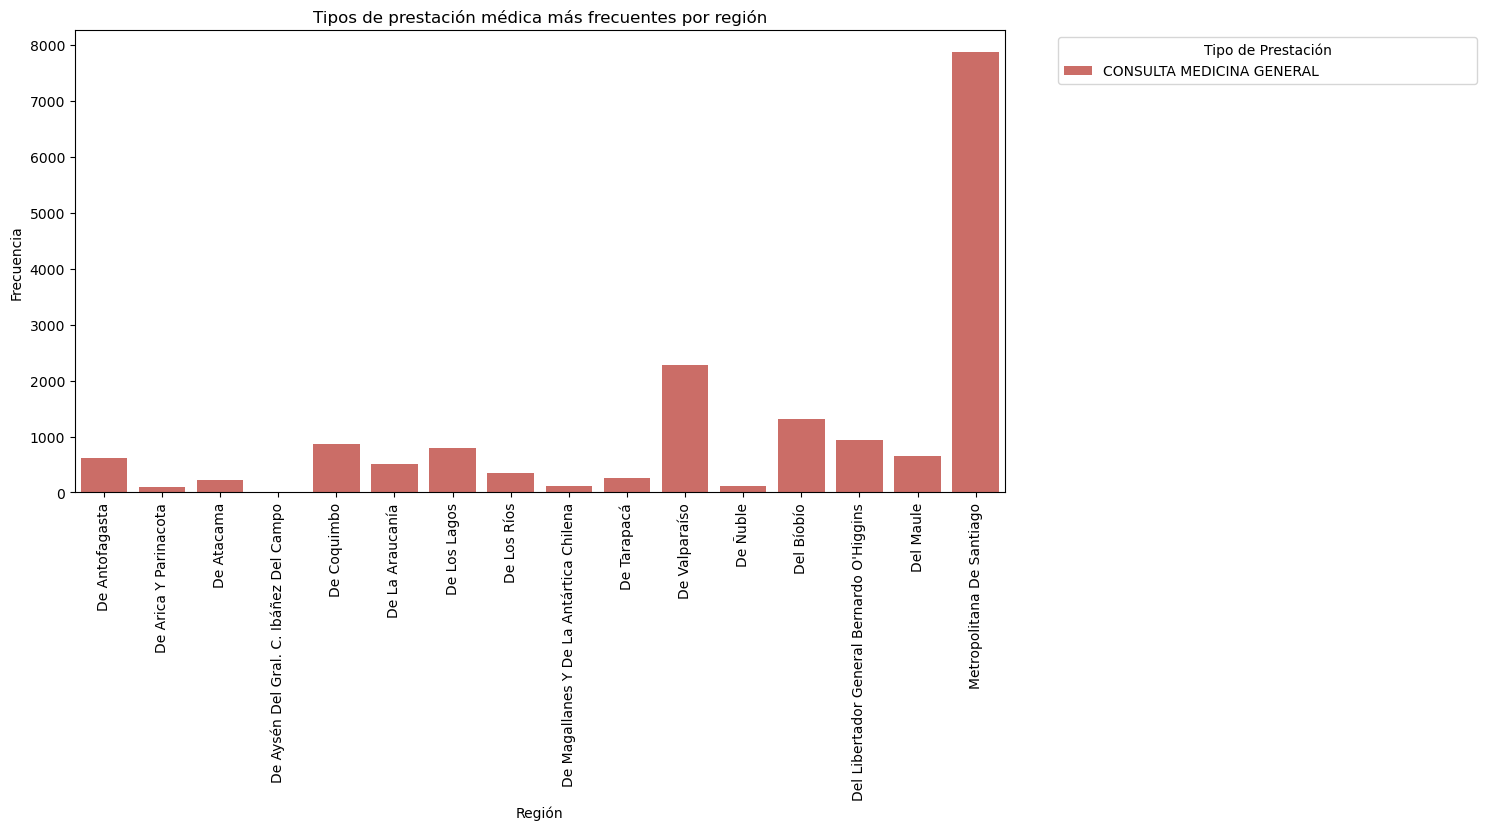

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))
plt.title('Tipos de prestación médica más frecuentes por región')
plt.xlabel('Región')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de Prestación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

 A continuación, se presenta un gráfico de barras donde se muestra la frecuencia de cada tipo de prestación médica en función de la región. El eje X representa las regiones de emisión, mientras que el eje Y indica la frecuencia de cada tipo de prestación. Los colores en las barras corresponden a los distintos tipos de prestaciones médicas, facilitando la visualización de cuál es más común en cada región.

**Análisis del Gráfico**

En este análisis, la prestación médica más frecuente en todas las regiones es la "CONSULTA MÉDICA GENERAL". Sin embargo, aunque esta prestación se repite en todas las regiones, las frecuencias varían, con algunas regiones presentando una mayor cantidad de consultas que otras.

**Distribución geográfica de los datos**

En segunda instancia, mostraremos geográficamente la frecuencia de las prestaciones médicas por región. Utilizaremos el shapefile con la información geográfica de Chile y el dataframe con los datos de las prestaciones más frecuentes, emparejando las regiones utilizando la librería fuzzywuzzy para asegurar que los nombres coincidan correctamente. 

In [22]:
# se usa este archivo para poder graficar el mapa de Chile por regiones
mapa = gpd.read_file("data/Regiones/Regional.shp")
mapa

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
0,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-7727277.278 -1997230.768, -7726464...."
1,1085,2,1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-7810213.515 -2298008.280, -78..."
2,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78..."
3,1087,15,12,133053.142345,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-7494057.535 -7542535.383, -74..."
4,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-8413517.696 -6234055.255, -84..."
5,1089,4,3,75661.248635,9.643906e+10,2.401741e+06,Región de Atacama,"MULTIPOLYGON (((-7932747.769 -3311218.615, -79..."
6,1090,5,4,40575.901682,5.498082e+10,2.065933e+06,Región de Coquimbo,"MULTIPOLYGON (((-7963268.900 -3784870.143, -79..."
7,1091,6,5,16322.970393,2.301475e+10,1.679609e+06,Región de Valparaíso,"MULTIPOLYGON (((-8991645.917 -3991821.789, -89..."
8,1092,7,13,15392.030737,2.225204e+10,1.064253e+06,Región Metropolitana de Santiago,"POLYGON ((-7873736.745 -3885505.642, -7873695...."
9,1093,13,10,48408.371357,8.771834e+10,7.874158e+06,Región de Los Lagos,"MULTIPOLYGON (((-8331768.181 -5403721.402, -83..."


Para emparejar nombres similares, utilizamos la librería [fuzzywuzzy](https://stackoverflow.com/questions/41171665/python-fuzzywuzzys-process-extract-how-does-it-work), específicamente la función `process.extractOne()`, que nos permite buscar la coincidencia más cercana entre cadenas de texto. En este caso, la utilizaremos para emparejar los nombres de las regiones entre el dataframe `beneficiarios_df` y el shapefile `mapa`.

<Figure size 1200x800 with 0 Axes>

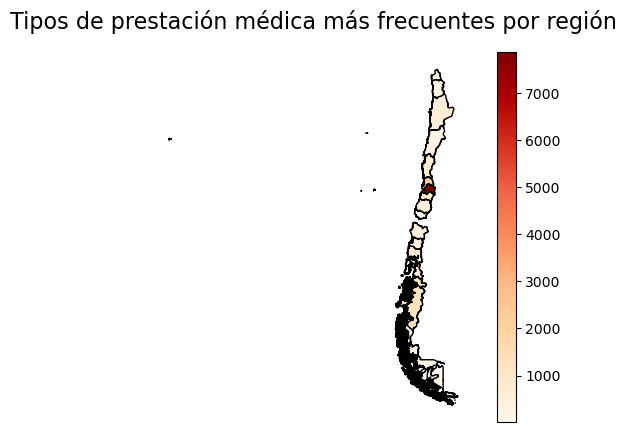

In [23]:
# Emparejar nombres similares
nombres_mapa = mapa['Region'].unique()
nombres_prestaciones = prestaciones_mas_frecuentes['REGION_EMISION'].unique()

# Crear un diccionario de coincidencias
matches = {nombre: process.extractOne(nombre, nombres_mapa)[0] for nombre in nombres_prestaciones}

# Reemplazar nombres en prestaciones_mas_frecuentes
prestaciones_mas_frecuentes['Region'] = prestaciones_mas_frecuentes['REGION_EMISION'].map(matches)

# Unir con el shapefile
mapa_regiones = mapa.merge(prestaciones_mas_frecuentes, on='Region', how='left')

plt.figure(figsize=(12, 8))
mapa_regiones.plot(column='FRECUENCIA', cmap='OrRd', legend=True, edgecolor='black')
plt.title('Tipos de prestación médica más frecuentes por región', fontsize=16)
plt.axis('off')
plt.show()

A continuación, se presenta un mapa geográfico donde se visualiza la frecuencia de las prestaciones médicas más comunes por región. En este mapa, las regiones están representadas mediante colores que indican la frecuencia de la prestación médica más frecuente en cada una. Las regiones con colores más intensos muestran una mayor frecuencia, lo que facilita la comparación visual de las diferencias en la distribución de las prestaciones médicas a lo largo del país.

**Análisis del Gráfico**

En este análisis, por ejemplo, la Región Metropolitana de Santiago presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, tienen frecuencias considerablemente más bajas. Esta diferencia en las frecuencias refleja la diversidad en la distribución y demanda de servicios médicos a lo largo del país.

### ¿Qué podría salir mal?

- Limitaciones de los datos:
  
  1. Dado que los nombres de las regiones no coinciden exactamente entre el dataframe utilizado y el shapefile, podría haber problemas al graficar si no se cuenta con el conocimiento o las herramientas adecuadas para realizar el emparejamiento correctamente.
  2. Las frecuencias de las prestaciones podrían no reflejar la realidad debido a posibles errores de registro o limitaciones en la cobertura de los datos.

- Sesgos inherentes:
  1. El análisis no considera factores como la calidad del servicio, el acceso físico a centros médicos, o las diferencias en infraestructura entre regiones.

### Conclusion

En este análisis, se exploró la frecuencia de las prestaciones médicas más comunes en diversas regiones del país, utilizando tanto un gráfico de barras como un mapa geográfico para visualizar los resultados. Se identificó que la prestación médica más frecuente en todas las regiones es la "Consulta Médica General", aunque las frecuencias varían significativamente entre las regiones. La Región Metropolitana de Santiago, por ejemplo, presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, muestran una demanda mucho menor.

Este patrón de distribución refleja no solo las diferencias en el acceso y la demanda de servicios médicos, sino también posibles disparidades regionales en infraestructura y atención sanitaria. Las regiones más urbanizadas tienden a tener una mayor concentración de consultas, mientras que las zonas más alejadas podrían enfrentar desafíos relacionados con la disponibilidad y el acceso a estos servicios.

En resumen, este análisis destaca la importancia de considerar las diferencias regionales en el acceso a la atención médica y la necesidad de políticas públicas que aborden estas desigualdades para mejorar la cobertura y la calidad de los servicios de salud en todo el país.